                                            **Data and Outlier Visualization**
                                            
                                                      Aman Panwar

The main goals of this project are to demonstrate how to:

1. Access the data stored in MySQL via Python
2. Effectively visualize data that has large range of values
3. Detect outliers through machine learning models and visualization packages

**Part 1: Cleaning the data**

In [1]:
#access original dataset
import pandas as pd
d1=pd.read_csv('Javelin1.csv')

#find % of missing values in data
d1.isnull().sum()/(d1.shape[0])*100


FileNotFoundError: [Errno 2] No such file or directory: 'Javelin1.csv'

In [ ]:
#Since the % of missing values is less than 3%, rows with any missing values were removed
d1 = d1.dropna(how='any',axis=0) 
d1.isnull().sum()

**Part 2: Connecting to MySQL database**

import mysql.connector

mydb = mysql.connector.connect(
  host="127.0.0.1",
  user="root",
  password='***',
  database="new_schema"
)

mycursor = mydb.cursor()

#selects all data from database
mycursor.execute("SELECT * FROM javelin_2")

data = mycursor.fetchall()

#creates a dataframe with relevant columns
d_o=pd.DataFrame(data,columns =['Name','VD','CL','IonState','LogD']) 

d_o.info()


**Part 3: Visualizing data with large range of values**

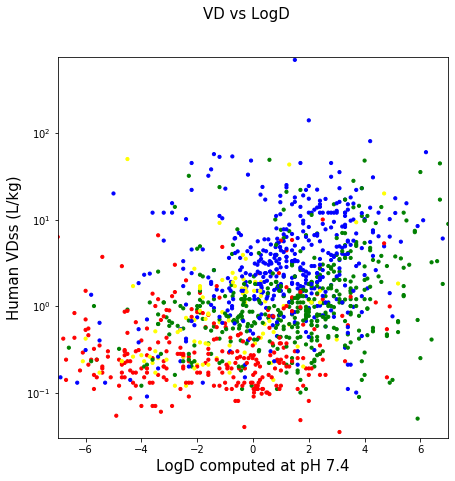

In [9]:
df=d1

import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

#assign different color to different ionstate
colors = {'anionic':'red', 'neutral':'green', 'cationic':'blue', 'zwitterionic':'yellow'}

#to decide xy limits
df['VD'].max()
df['VD'].min()
df['LogD'].max()
df['LogD'].min()

In [ ]:
#creates a scatter plot
ax.scatter(df['LogD'], df['VD'], c=df['IonState'].map(colors),s=10)
plt.ylim([0.03, 750])
plt.xlim([-7,7])

'''The VD column has values ranging from 0.03 to 700, so due to the wide range of values,it is difficult to visualize all values
in a single plot therefore symmetrical log transformation is used. Symmetrical log transformation decreases the 
overall scale. 
Since the log of values that are smaller than 1 is negative therefore values till 0.03 are plotted linearly using linthreshy.
'''
plt.yscale('symlog',linthreshy=0.03)
fig.set_figwidth(7)
fig.set_figheight(7)

fig.suptitle('VD vs LogD', fontsize=15)
plt.xlabel('LogD computed at pH 7.4', fontsize=15)
plt.ylabel('Human VDss (L/kg)', fontsize=15)

plt.show()

**Outlier Detection**

**Isolation Forest Outlier Detection**

Isolation Forest outlier detection technique, a tree ensemble method, is built on the basis of decision trees. It's principle is that an outlier will need very few partitions to get classified. 

It is useful for high dimensional data (data with several variables) because it is computationally effcient as it does not   require any computationally intensive tasks like density or distance calculation.

https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest

In [10]:
#Isolation Forest outlier 
import plotly.express as px
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import seaborn as sns 

import warnings
warnings.filterwarnings("ignore")

data=d_o
x1='LogD';x2='VD'
X = data[[x1,x2]]

clf = IsolationForest(max_samples='auto', random_state = 1, contamination= 0.01)
preds = clf.fit_predict(X)
data['isoletionForest_outliers'] = preds
data['isoletionForest_outliers'] = data['isoletionForest_outliers'].astype(str)
data['isoletionForest_scores'] = clf.decision_function(X)
print(data['isoletionForest_outliers'].value_counts())

#There are 26 outliers, denoted by -1, in this dataset.

1     1274
-1      26
Name: isoletionForest_outliers, dtype: int64


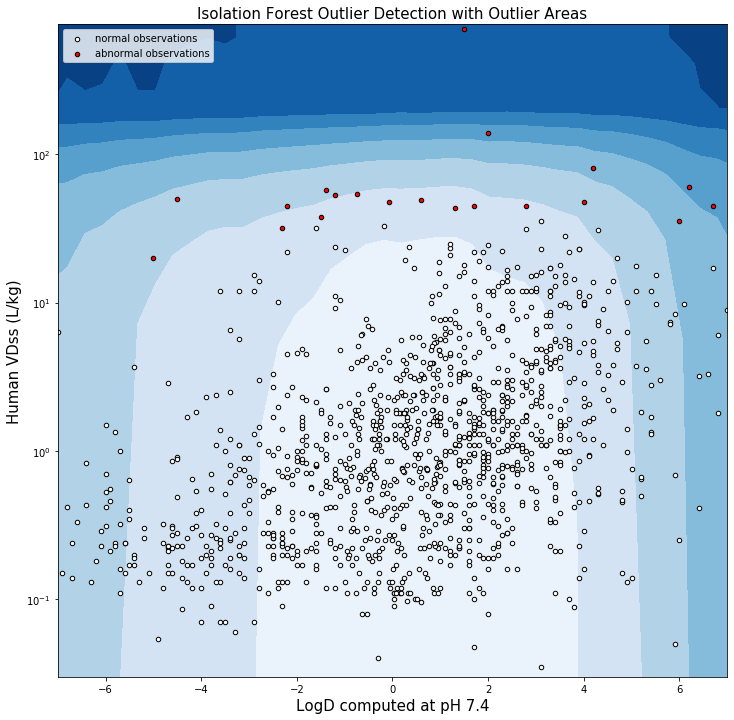

In [6]:
##Isolation Forest outlier plot

X_inliers = data.loc[data['isoletionForest_outliers']=='1'][[x1,x2]]
X_outliers = data.loc[data['isoletionForest_outliers']=='-1'][[x1,x2]]

xx, yy = np.meshgrid(np.linspace(X.iloc[:, 0].min(), X.iloc[:, 0].max(), 50), np.linspace(X.iloc[:, 1].min(), X.iloc[:, 1].max(), 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(30, 7))
plt.title("Isolation Forest Outlier Detection with Outlier Areas", fontsize = 15, loc='center')
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

inl = plt.scatter(X_inliers.iloc[:, 0], X_inliers.iloc[:, 1], c='white', s=20, edgecolor='k')
outl = plt.scatter(X_outliers.iloc[:, 0], X_outliers.iloc[:, 1], c='red',s=20, edgecolor='k')

plt.axis('tight')
plt.xlim((X.iloc[:, 0].min(), X.iloc[:, 0].max()))
plt.ylim((X.iloc[:, 1].min(), X.iloc[:, 1].max()))
plt.legend([inl, outl],["normal observations", "abnormal observations"],loc="upper left")

plt.yticks([0.01,0.03,0.1,0.3,1,3,10,30,100,300,1000])
plt.yscale('symlog',linthreshy=0.03)
fig.set_figwidth(12)
fig.set_figheight(12)

plt.xlabel('LogD computed at pH 7.4', fontsize=15)
plt.ylabel('Human VDss (L/kg)', fontsize=15)

plt.ylim([0.03, 750])
plt.xlim([-7,7])

plt.show()

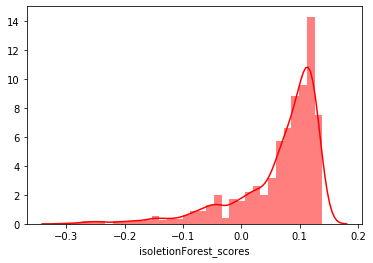

In [7]:
ax.set_title('Distribution of Isolation Forest Scores', fontsize = 15, loc='center')
fig.set_figwidth(12)
fig.set_figheight(12)
sns.distplot(data['isoletionForest_scores'],color='red',label='if',hist_kws = {"alpha": 0.5});

The distribution plot can be used to identify correct contamination value. Contamination parameter, decided by user, sets the percentage of points in data to be anomalous.If we change the contamination value, the isoletionForest_scores will change, but the distribution will stay the same. The algorithm will adjust the cutoff for outliers in the distribution plot.

**Local Outlier Factor (LOF)**
The LOF method uses the density of a certain point compared to the density of its neighbors to find if a point is an outlier.
If the density of a point is much smaller than the densities of its neighbors (LOF ≫1), the point is far from dense areas and, hence, an outlier.

It is useful in data where there are multiple clusters as it can find local outlier.
https://dl.acm.org/doi/abs/10.1145/1645953.1646195

In [11]:
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
import plotly.express as px

import plotly.figure_factory as ff

clf = LocalOutlierFactor(n_neighbors=11)
y_pred = clf.fit_predict(X)

data['localOutlierFactor_outliers'] = y_pred.astype(str)
print(data['localOutlierFactor_outliers'].value_counts())
data['localOutlierFactor_scores'] = clf.negative_outlier_factor_

1     1170
-1     130
Name: localOutlierFactor_outliers, dtype: int64


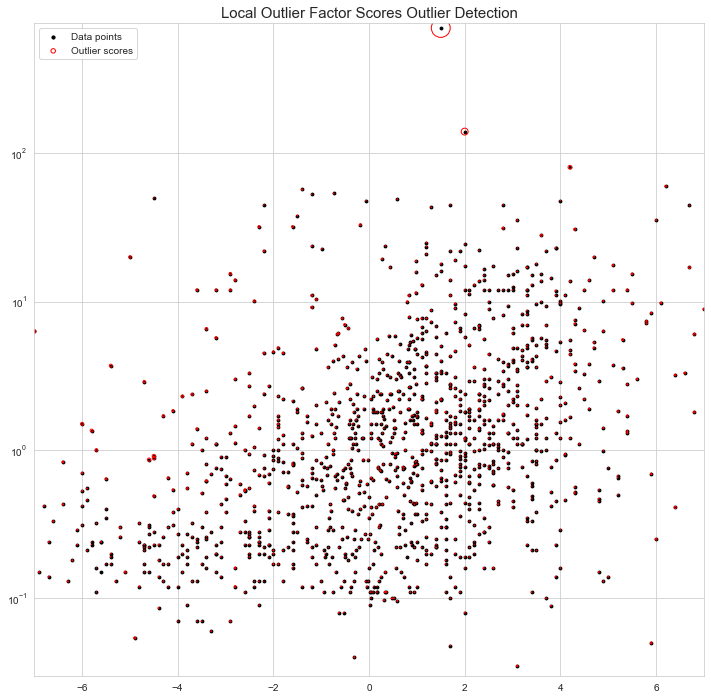

In [12]:
#LOF plot
fig, ax = plt.subplots(figsize=(30, 7))
ax.set_title('Local Outlier Factor Scores Outlier Detection', fontsize = 15, loc='center')

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], color='k', s=8., label='Data points')
radius = (data['localOutlierFactor_scores'].max() - data['localOutlierFactor_scores']) / (data['localOutlierFactor_scores'].max() - data['localOutlierFactor_scores'].min())
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=5000 * radius, edgecolors='r', facecolors='none', label='Outlier scores')
plt.axis('tight')
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.yscale('symlog',linthreshy=0.03)
fig.set_figwidth(12)
fig.set_figheight(12)
plt.ylim([0.03, 750])
plt.xlim([-7,7])

plt.show()

In this plot,bigger the local outlier, bigger the circle around it.